In [2]:
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
import os
import random
from tqdm import tqdm
from math import cos, radians

In [ ]:
resolution = 592.747
round_resolution = round(resolution)
image_path = 'dataset/images/'
label_path = image_path.replace('images', 'labels')
image_names = os.listdir(label_path)

28_-121_v
14_-98_h
8_-112_h


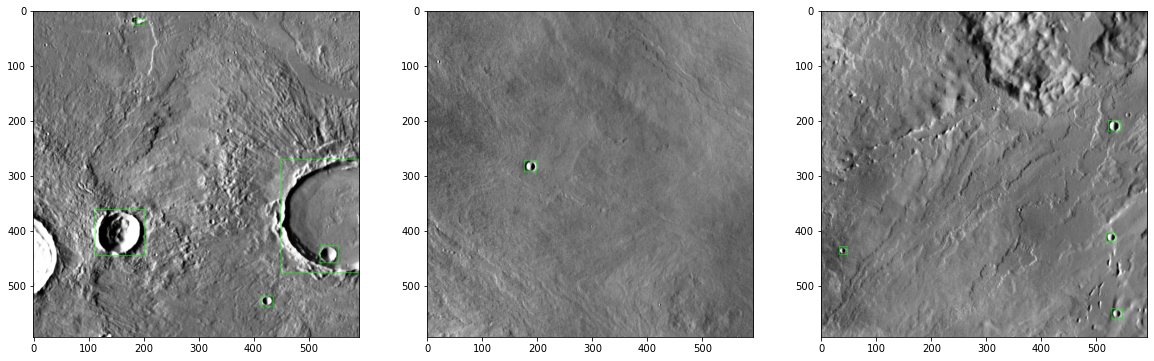

In [ ]:
random.shuffle(image_names)
fig, ax = plt.subplots(1, 3, figsize=(20, 6))

for i in range(3):
    image_name = image_names[i][:-4]
    im = cv2.imread(image_path + image_name + '.png')
    label_name = image_name + '.txt'
    print(image_name)
    f = open(label_path + label_name, 'r')
    for line in f.readlines():
        c, x, y, w, h, id = line.split(' ')
        x1 = int((float(x) - float(w) / 2) * 593)
        y1 = int((float(y) - float(h) / 2) * 593)
        x2 = int((float(x) + float(w) / 2) * 593)
        y2 = int((float(y) + float(h) / 2) * 593)
        cv2.rectangle(im, (x1, y1), (x2, y2), (0, 255, 0), 1)
    f.close()
    ax[i].imshow(im)

In [ ]:
import os
import random
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

image_list = os.listdir('dataset/images')

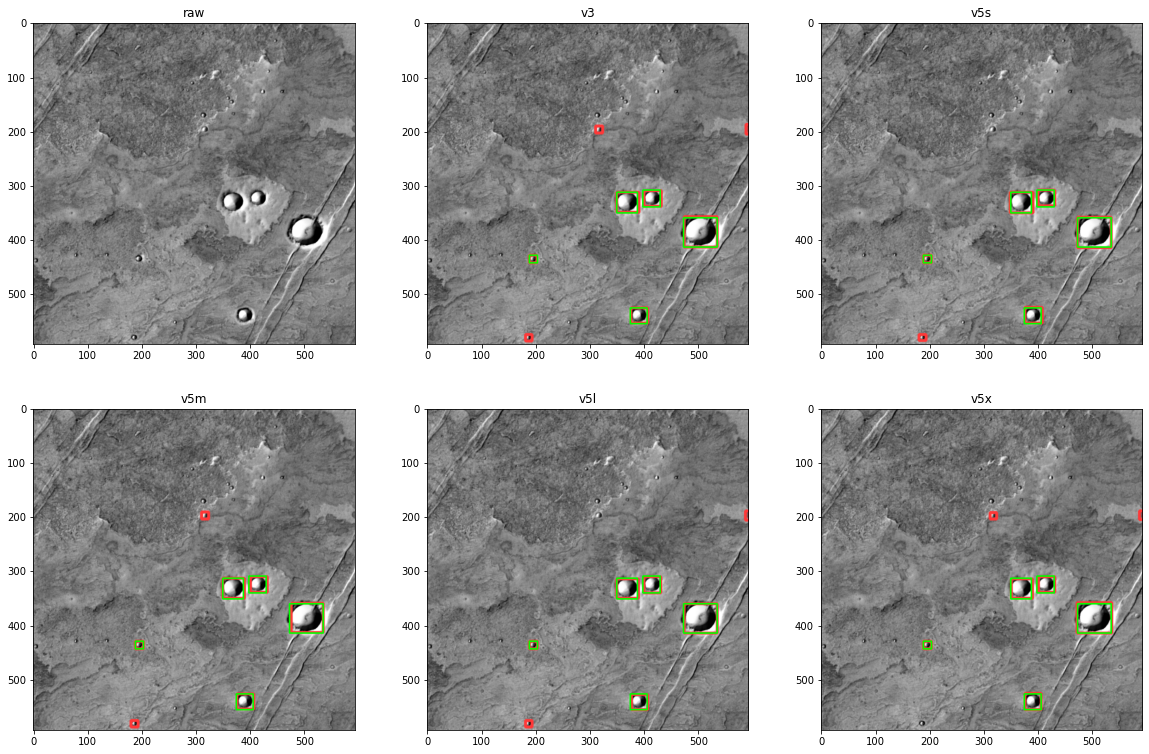

In [ ]:
random.shuffle(image_list)
for image_name in image_list[:1]:
    plt.figure(figsize=(20, 13))

    # origin pic
    plt.subplot(2, 3, 1)
    raw_pic = mpimg.imread('dataset/images/' + image_name)
    plt.imshow(raw_pic, cmap='gray')
    plt.title('raw')

    # v3
    plt.subplot(2, 3, 2)
    pic = mpimg.imread('detect/v3/' + image_name)
    plt.imshow(pic)
    plt.title('v3')

    # v5s
    plt.subplot(2, 3, 3)
    pic = mpimg.imread('detect/v5s/' + image_name)
    plt.imshow(pic)
    plt.title('v5s')

    # v5m
    plt.subplot(2, 3, 4)
    pic = mpimg.imread('detect/v5m/' + image_name)
    plt.imshow(pic)
    plt.title('v5m')

    # v5l
    plt.subplot(2, 3, 5)
    pic = mpimg.imread('detect/v5l/' + image_name)
    plt.imshow(pic)
    plt.title('v5l')

    # v5x
    plt.subplot(2, 3, 6)
    pic = mpimg.imread('detect/v5x/' + image_name)
    plt.imshow(pic)
    plt.title('v5x')

# Select 2a2b dataset

In [3]:
# f = open('combined/loss_rank.csv', 'r')
# print(f.readline())
# rank = [(line.split(',')[0], *[float(loss) for loss in line.split(',')[1:]]) for line in f.read().splitlines()]
# f.close()

rank = pd.read_csv('combined/loss_rank.csv')
rank.columns

robbins_rank = pd.read_csv('robbins/loss_rank.csv')


In [4]:
index = np.array(rank['box'] < 0.02) & np.array(rank['obj'] < 0.0026)
data_2a = rank[index]
data_2a_set = set('_'.join(name.split('_')[:2]) for name in data_2a['img'])
len(data_2a_set) / len(rank) * 4

0.2

In [5]:
index = np.array(rank['box'] < 0.02) & np.array(0.018 < rank['obj']) & np.array(rank['obj'] < 0.08)
data_2b = rank[index]
data_2b_set = set('_'.join(name.split('_')[:2]) for name in data_2b['img'])
len(data_2b_set) / len(rank) * 4

0.20634920634920634

In [6]:
robbins_2c = np.array([loss[1:3] for i, loss in robbins_rank.iterrows() if '_'.join(loss[0].split('_')[:2]) in data_2a_set])
robbins_2d = np.array([loss[1:3] for i, loss in robbins_rank.iterrows() if '_'.join(loss[0].split('_')[:2]) in data_2b_set])

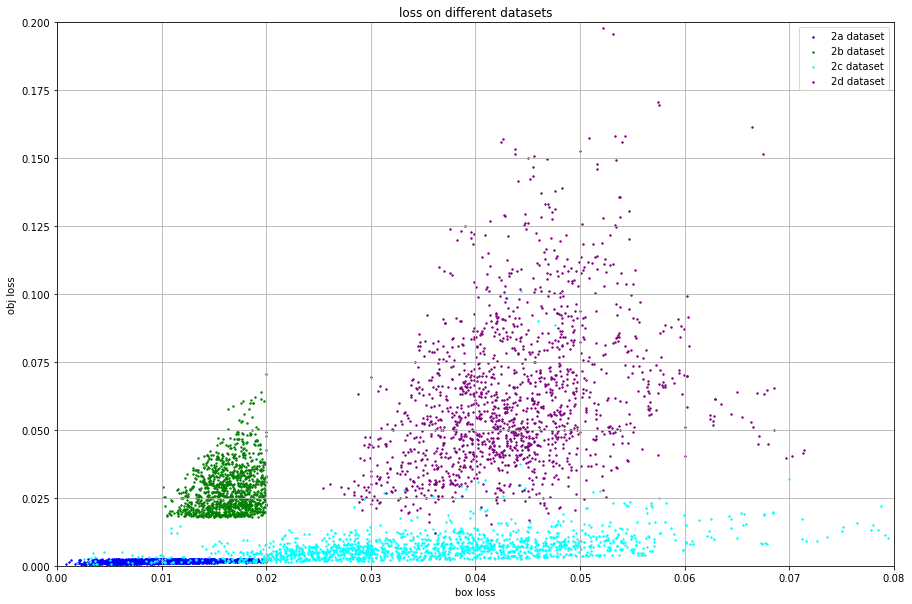

In [12]:
plt.figure(figsize=(15,10))
# plt.scatter(rank['box'], rank['obj'], s=2, color='r', label='combined dataset')
plt.scatter(data_2a['box'], data_2a['obj'], s=2, color='b', label='2a dataset')
plt.scatter(data_2b['box'], data_2b['obj'], s=2, color='g', label='2b dataset')
# plt.scatter(robbins_rank['box'], robbins_rank['obj'], s=1, color='yellow', label='robbins dataset')
plt.scatter(robbins_2c[:, 0], robbins_2c[:, 1], s=2, color='cyan', label='2c dataset')
plt.scatter(robbins_2d[:, 0], robbins_2d[:, 1], s=2, color='purple', label='2d dataset')
plt.grid()
plt.xlabel('box loss')
plt.ylabel('obj loss')
plt.xlim([0, 0.08])
plt.ylim([0, 0.2])
plt.title('loss on different datasets')
plt.legend()
plt.show()

### save 2a 2b

In [ ]:
def save(name: str, data: set):
    f = open('combined/' + name, 'w')
    for img in tqdm(data):
        f.write('../Robbins-to-THEMIS/combined/images/' + img + '.png\n')
        f.write('../Robbins-to-THEMIS/combined/images/' + img + '_v.png\n')
        f.write('../Robbins-to-THEMIS/combined/images/' + img + '_h.png\n')
        f.write('../Robbins-to-THEMIS/combined/images/' + img + '_vh.png\n')
    f.close()

save('data_2a.txt', data_2a_set)
save('data_2b.txt', data_2b_set)

100%|██████████| 390/390 [00:00<00:00, 317812.04it/s]


### save 2c 2d

In [ ]:
for name in tqdm(os.listdir('combined')):
    if not name.endswith('txt'):
        continue
    f = open('combined/' + name, 'r')
    buffer = f.read()
    f.close()
    buffer = buffer.replace('combined', 'robbins')
    f = open('robbins/' + name, 'w')
    f.write(buffer)
    f.close()

os.system('mv robbins/data_2a.txt robbins/data_2c.txt')
os.system('mv robbins/data_2b.txt robbins/data_2d.txt')

100%|██████████| 14/14 [00:00<00:00, 2148.49it/s]


0

## 2e dataset

In [93]:
os.system('mkdir 2e')
os.system('mkdir 2e/images')
os.system('mkdir 2e/labels')
os.system('mkdir 2e/yolo_labels')

0

In [94]:
f = open('combined/data_2a.txt', 'r')
data_2a = f.read()
f.close()

f = open('combined/data_2b.txt', 'r')
data_2b = f.read()
f.close()

for line in tqdm((data_2a + data_2b).splitlines()):
    img_name = line.split('/')[-1]
    os.system('cp combined/images/%s 2e/images/%s' % (img_name, img_name))

    lbl_name = img_name[:-3] + 'txt'
    os.system('cp combined/labels/%s 2e/labels/%s' % (lbl_name, lbl_name))
    os.system('cp combined/yolo_labels/%s 2e/yolo_labels/%s' % (lbl_name, lbl_name))



100%|██████████| 3072/3072 [00:19<00:00, 157.23it/s]


# Count confidence

In [2]:
def xywh2xyxy(x, y, w, h):
    x, y, w, h = float(x), float(y), float(w), float(h)
    return x - w / 2, y - h / 2, x + w / 2, y + h / 2

# calculate area of a box
def area(x1, y1, x2, y2):
    return (x2 - x1) * (y2 - y1)

# calculate iou of two boxes
def iou(box1, box2):
    '''
    box1 = [x1, y1, x2, y2]
    box2 = [x1, y1, x2, y2]
    '''
    # calculate intersection
    x1 = max(box1[0], box2[0])
    y1 = max(box1[1], box2[1])
    x2 = min(box1[2], box2[2])
    y2 = min(box1[3], box2[3])

    # no overlap
    if x1 > x2 or y1 > y2:
        return 0.
    
    intersection_area = area(x1, y1, x2, y2)
    union_area = area(*box1) + area(*box2) - intersection_area
    
    return intersection_area / union_area

def find_max_iou_box(box, box_list):
    '''
    box = [x1, x2, x3, x4]
    box_list = [box1, box2, ...]
    '''
    if len(box_list) == 0:
        return 0, None

    max_iou = 0
    max_iou_box = None

    for candi in box_list:
        this_iou = iou(box, candi)
        if this_iou > max_iou:
            max_iou = this_iou
            max_iou_box = candi
    
    return max_iou, max_iou_box


def count_true_false(image_name_list, path, confidence_thre=0):

    true_list = []
    false_list = []
    false_negtive = []

    for img_name in tqdm(image_name_list):
        gt_label_file = open(path + '/labels/' + img_name[:-4] + '.txt', 'r')

        gt_labels = []
        # show gt labels
        for line in gt_label_file.read().splitlines():
            x1, y1, x2, y2 = xywh2xyxy(*line.split()[1: 5])
            gt_labels.append((x1, y1, x2, y2))
        
        gt_label_file.close()

        lat = int(img_name.split('_')[0])
        w_scale = cos(radians(lat))

        yolo_label_file = open(path + '/yolo_labels/' + img_name[:-4] + '.txt', 'r')
        lines = yolo_label_file.read().splitlines()
        yolo_label_file.close()

        lines.sort(key=lambda line:-float(line.split()[5]))

        for line in lines:
            x1, y1, x2, y2 = xywh2xyxy(*line.split()[1: 5])
            conf = float(line.split()[5])
            ratio = (x2 - x1) / (y2 - y1)
            if conf < confidence_thre or ratio > 2 or ratio < 0.5:
                continue
            
            w = (x2 - x1) * 593 * w_scale
            h = (y2 - y1) * 593
            size = max(w, h)
            max_iou, max_iou_box = find_max_iou_box((x1, y1, x2, y2), gt_labels)

            if max_iou > 0.5:
                gt_labels.remove(max_iou_box)
                true_list.append((size, conf))
            else:
                false_list.append((size, conf))

        for label in gt_labels:
            x1, y1, x2, y2 = label
            w = (x2 - x1) * 593 * w_scale
            h = (y2 - y1) * 593
            size = max(w, h)
            false_negtive.append(size)


    return true_list, false_list, false_negtive


def hist_by_conf(true_positive, false_positive, false_negative, conf, bins):

    true_positive_sizes = []
    false_positive_sizes = []

    for x in true_positive:
        if x[1] > conf:
            true_positive_sizes.append(x[0])
        else:
            false_negative.append(x[0])


    false_positive_sizes = [x[0] for x in false_positive if x[1] > conf]

    tp_y, x = np.histogram(true_positive_sizes, bins=bins)
    fp_y, x = np.histogram(false_positive_sizes, bins=bins)
    fn_y, x = np.histogram(false_negative, bins=bins)

    return tp_y, fp_y, fn_y


100%|██████████| 3072/3072 [00:01<00:00, 2938.00it/s]
<ipython-input-3-cfba437745ea>:20: RuntimeWarning: invalid value encountered in true_divide
  precision = tp_y / (tp_y + fp_y)
<ipython-input-3-cfba437745ea>:21: RuntimeWarning: invalid value encountered in true_divide
  recall = tp_y / (tp_y + fn_y)
<ipython-input-3-cfba437745ea>:20: RuntimeWarning: invalid value encountered in true_divide
  precision = tp_y / (tp_y + fp_y)
<ipython-input-3-cfba437745ea>:21: RuntimeWarning: invalid value encountered in true_divide
  recall = tp_y / (tp_y + fn_y)
<ipython-input-3-cfba437745ea>:20: RuntimeWarning: invalid value encountered in true_divide
  precision = tp_y / (tp_y + fp_y)
<ipython-input-3-cfba437745ea>:21: RuntimeWarning: invalid value encountered in true_divide
  recall = tp_y / (tp_y + fn_y)
<ipython-input-3-cfba437745ea>:20: RuntimeWarning: invalid value encountered in true_divide
  precision = tp_y / (tp_y + fp_y)
<ipython-input-3-cfba437745ea>:21: RuntimeWarning: invalid value e

[  1.06732449   1.2158764    1.385104     1.57788496   1.79749747
   2.047676     2.33267478   2.65734014   3.02719293   3.44852241
   3.9284932    4.47526708   5.09814181   5.80770923   6.61603536
   7.53686559   8.58585843   9.78085175  11.14216612  12.69295037
  14.45957522  16.47208171  18.76469202  21.37639145  24.35159132
  27.74088421  31.60190422  36.00030709  41.01088661  46.71884649
  53.22124923  60.62866663  69.06706007  78.67992242  89.63071811
 102.10566281 116.31689    132.50605819 150.94846035 171.95770512
 195.89104972 223.15547496 254.21460591 289.59659569 329.90310661
 375.81954128 428.12669775 487.71404675 555.59485696]


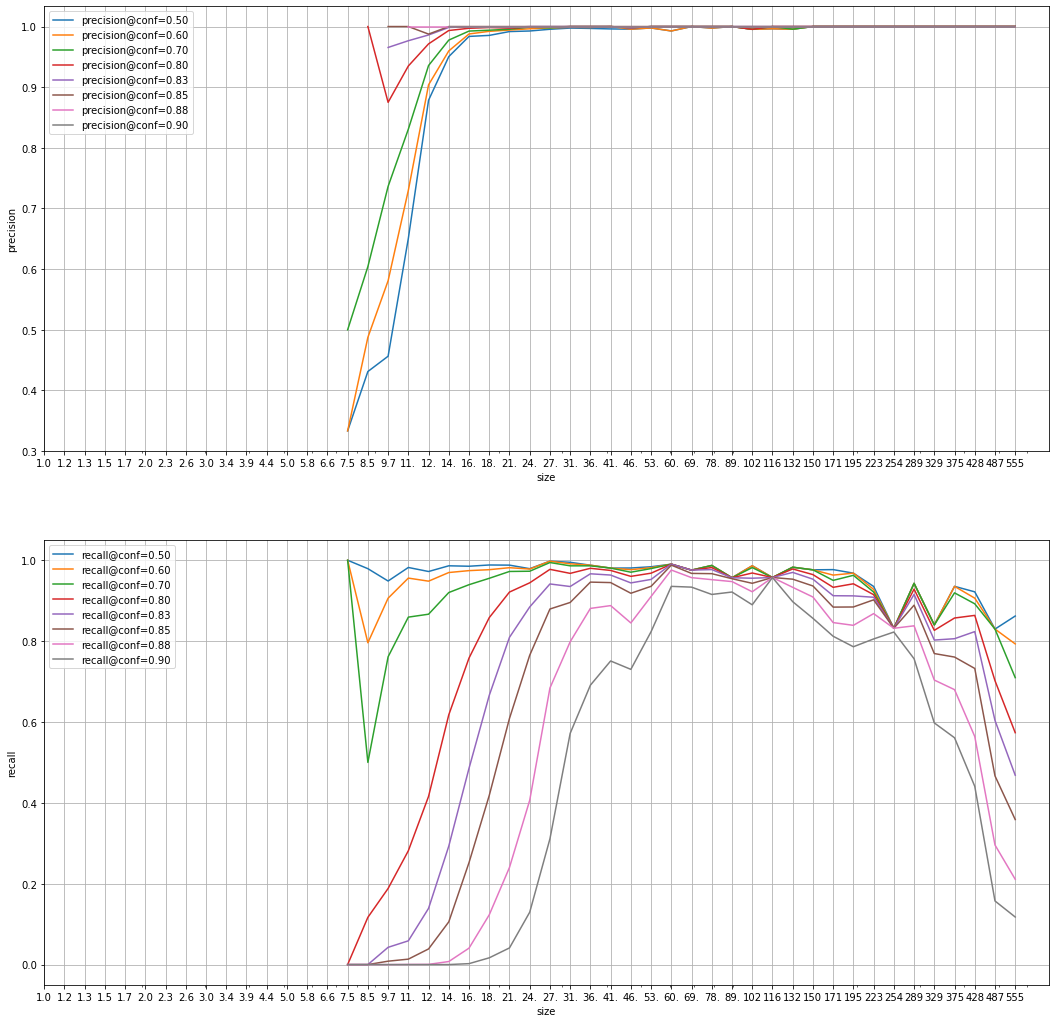

In [3]:


f = open('combined/data_2a.txt')
data_2a = [line.split('/')[-1] for line in f.read().splitlines()]
f.close()

f = open('combined/data_2b.txt')
data_2b = [line.split('/')[-1] for line in f.read().splitlines()]
f.close()

tp, fp, fn = count_true_false(data_2a + data_2b, 'combined')

# t_ben, f_ben = count_true_false(os.listdir('bendix/yolo_labels'), 'bendix')
# f.close()
bins = np.logspace(0, 1, 50, base=593)
x = (bins[1:] * bins[:-1])**0.5

plt.figure(figsize=(18,18))

for conf in [0.5, 0.6, 0.7, 0.8, 0.83, 0.85, 0.88, 0.9]:
    tp_y, fp_y, fn_y = hist_by_conf(tp, fp, fn, conf, bins)
    precision = tp_y / (tp_y + fp_y)
    recall = tp_y / (tp_y + fn_y)
    plt.subplot(2, 1, 1)
    plt.semilogx(x, precision, label='precision@conf=%.2f'%conf)
    plt.subplot(2, 1, 2)
    plt.semilogx(x, recall, label='recall@conf=%.2f'%conf)

print(x)

plt.subplot(2, 1, 1)
plt.legend()
plt.ylabel('precision')
plt.xlabel('size')
plt.xticks(ticks=x, labels=[str(i)[:3] for i in x])
plt.grid(True)

plt.subplot(2, 1, 2)
plt.legend()
plt.ylabel('recall')
plt.xlabel('size')
plt.xticks(ticks=x, labels=[str(i)[:3] for i in x])
plt.grid(True)
plt.show()

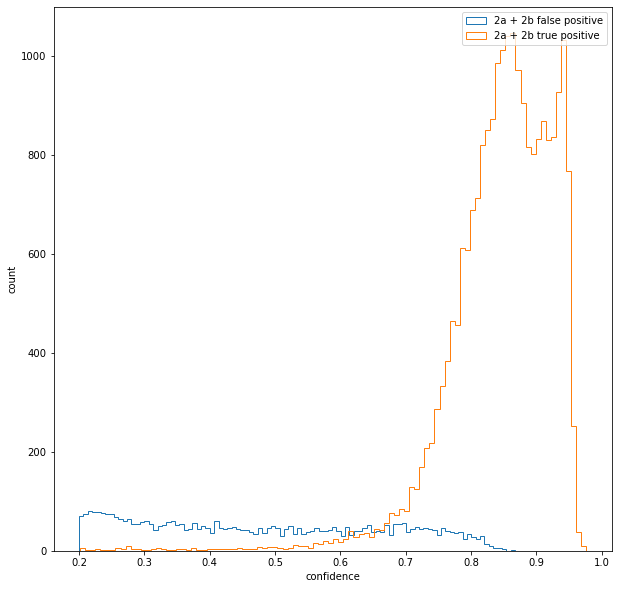

In [90]:

plt.figure(figsize=(10,10))

tp_size = [x[1] for x in tp]
fp_size = [x[1] for x in fp]

plt.hist(fp_size, bins=100, label='2a + 2b false positive', histtype='step')
plt.hist(tp_size, bins=100, label='2a + 2b true positive', histtype='step')


plt.legend()
plt.xlabel('confidence')
plt.ylabel('count')
plt.show()

# select bendix top 10% test set

In [3]:
bendix_rank = pd.read_csv('bendix/loss_rank.csv')
img_rank = list(bendix_rank['img'])
img_rank.reverse()
used_set = set(('tharsis', 'phoenicislacus', 'elysium', 'aeolis'))
img_rank = [img for img in img_rank if img.split('_')[0] not in used_set]
def count(img_list):
    count = 0
    for img in img_list:
        f = open('bendix/labels/' + img + '.txt')
        count += len(f.read().splitlines())
        f.close()
    return count

In [20]:
# save 10 % craters 
data_3 = img_rank[:600]

f = open('bendix/test.txt', 'w')
for img in data_3:
    f.write('../Robbins-to-THEMIS/bendix/images/' + img + '.png\n')
f.close()

print('test crater count', count(data_3))


test crater count 757


In [21]:
# save rest images
rest_img = [img[:-4] for img in os.listdir('bendix/labels') if img[:-4] not in img_rank[:600]]

random.shuffle(rest_img)

# train dataset
train_len = int(len(rest_img) * 0.9)
f = open('bendix/train.txt', 'w')
for img in rest_img[:train_len]:
    f.write('../Robbins-to-THEMIS/bendix/images/' + img + '.png\n')
f.close()

# valid dataset
f = open('bendix/valid.txt', 'w')
for img in rest_img[train_len:]:
    f.write('../Robbins-to-THEMIS/bendix/images/' + img + '.png\n')
f.close()

print('train crater count', count(rest_img[:train_len]))
print('valid crater count', count(rest_img[:train_len]))

6291
